In [1]:
import numpy as np
import pandas as pd
import re
from scipy import stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor as rfr,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, SCORERS
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

%matplotlib inline
plt.style.use('ggplot')
from IPython.display import display
display.max_columns = None
display.max_rows = None

/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
train = pd.read_csv('../data/train_processed_ord.csv')
test_raw = pd.read_csv('../data/test.csv')
train_raw=pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test_processed_ord.csv')
yt, lmda = stats.boxcox(train['SalePrice']) # Boxcox of SalePrice
act_pred = train['SalePrice']
X = train.drop(columns='SalePrice')
X = X.loc[:, X.columns!='HouseStyle_2.5Fin'] #HouseStyle_2.5Fin in training.csv but not in test.csv

## Skewness (adjust Skewness of numeric columns)
#### 
Unnamed: 0                    int64
MSSubClass                    int64
LotFrontage                 float64
LotArea                       int64
YearBuilt                     int64
YearRemodAdd                  int64
MasVnrArea                  float64
BsmtFinSF1                  float64
BsmtFinSF2                  float64
BedroomAbvGr                  int64
KitchenAbvGr                  int64
TotRmsAbvGrd                  int64
Fireplaces                    int64
GarageYrBlt                 float64
GarageCars                  float64
GarageArea                  float64
WoodDeckSF                    int64
EnclosedPorch                 int64
3SsnPorch                     int64
ScreenPorch                   int64
PoolArea                      int64
MiscVal                       int64
IsPool                        int64 - not numerical
IsGarage                      int64 - not numerical
TotalFullBath               float64
TotalHalfBath               float64
TotalSF                     float64

In [4]:
numeric=X.loc[:, X.columns != 'IsPool']
numeric = numeric.loc[:, numeric.columns !='IsGarage']
numerical = numeric.dtypes[:27].index.to_list()
skewed = X[numerical].apply(lambda x: x.skew()).sort_values()
skewdf = pd.DataFrame({'Skew': skewed})
skewdf = skewdf[(skewdf)>0.75]
from scipy.special import boxcox1p
skewed = skewdf.index
lam = 0.15
for feat in skewed:
    X[feat] = boxcox1p(X[feat], lam)
    test[feat] = boxcox1p(test[feat], lam)
# newskewed = X[numerical].apply(lambda x: x.skew()).sort_values()

In [5]:
print(test.shape)
print(X.shape)

(1459, 177)
(1454, 177)


In [10]:
X_tr, X_val, y_tr, y_val = train_test_split(X, yt, test_size=0.2, random_state=1)

## Model: Ridge 

In [6]:
ridge = Ridge(normalize=True, alpha=0.046)
ridge.fit(X,yt)

Ridge(alpha=0.046, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [7]:
features_ridge={}
i = 0
for name in X.columns:
    features_ridge[name]=ridge.coef_[i]
    i += 1

ridge_features=[]
ridge_coefs=[]
for name in features_ridge:
    if features_ridge[name] > 1e-10:
        ridge_features.append(name)
        ridge_coefs.append(features_ridge[name])
ridge_features=pd.DataFrame(zip(ridge_features, ridge_coefs), columns=['features','coef']).sort_values(by='coef', ascending=False)

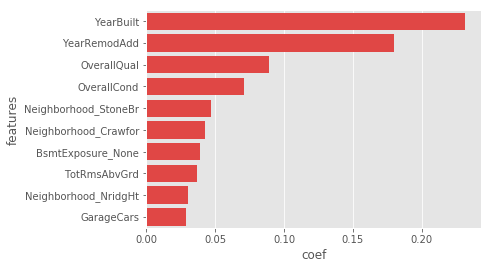

In [8]:
import seaborn as sns
df = ridge_features.sort_values("coef", ascending=False).head(10)
sns.barplot(x="coef", y="features", data=df,
            label="coef", color='#FA2E2B', )

### Ridge Prediction vs Actual

In [27]:
act_pred=train['SalePrice']

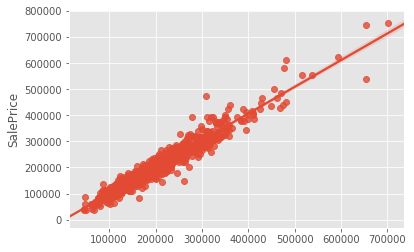

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

ridge.fit(X, yt)
ridge_pred=ridge.predict(X)
ridge_pred=((ridge_pred*lmda)+1)**(1/lmda)
sns.regplot(ridge_pred,act_pred)

## Model : Lasso 

In [24]:
lasso = Lasso(normalize=True, alpha=3.909090909090909e-05)
lasso.fit(X,yt)

Lasso(alpha=3.909090909090909e-05, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [25]:
features_lasso={}
i = 0
for name in X.columns:
    features_lasso[name]=lasso.coef_[i]
    i += 1

lasso_reduced_features=[]
lasso_reduced_coefs=[]
for name in features_lasso:
    if features_lasso[name] > 1e-10:
        lasso_reduced_features.append(name)
        lasso_reduced_coefs.append(features_lasso[name])
lasso_features=pd.DataFrame(zip(lasso_reduced_features,lasso_reduced_coefs), columns=['features','coef']).sort_values(by='coef', ascending=False)

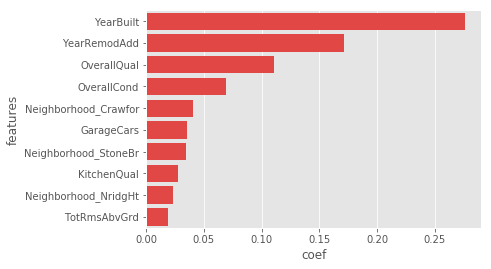

In [26]:
import seaborn as sns
df = lasso_features.sort_values("coef", ascending=False).head(10)
sns.barplot(x="coef", y="features", data=df,
            label="coef", color='#FA2E2B', )

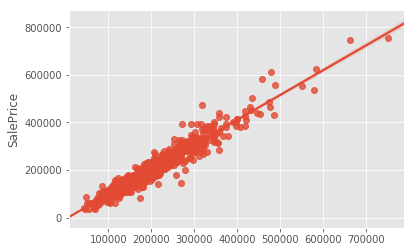

In [30]:
lasso.fit(X,yt)
lasso_pred=lasso.predict(X)
lasso_pred=((lasso_pred*lmda)+1)**(1/lmda)
sns.regplot(lasso_pred,act_pred)

### Elastic Net

In [31]:
net = ElasticNet(normalize=True, alpha=3.842105263157895e-05, l1_ratio=1)
net.fit(X,yt)

ElasticNet(alpha=3.842105263157895e-05, copy_X=True, fit_intercept=True,
           l1_ratio=1, max_iter=1000, normalize=True, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [32]:
features_net={}
i = 0
for name in X.columns:
    features_net[name]=net.coef_[i]
    i += 1

net_features=[]
net_coefs=[]
for name in features_lasso:
    if features_net[name] > 1e-10:
        net_features.append(name)
        net_coefs.append(features_net[name])
net_features=pd.DataFrame(zip(net_features,net_coefs), columns=['features','coef']).sort_values(by='coef', ascending=False)

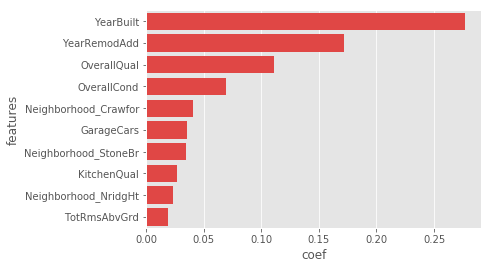

In [33]:
import seaborn as sns
df = net_features.sort_values("coef", ascending=False).head(10)
sns.barplot(x="coef", y="features", data=df,
            label="coef", color='#FA2E2B', )

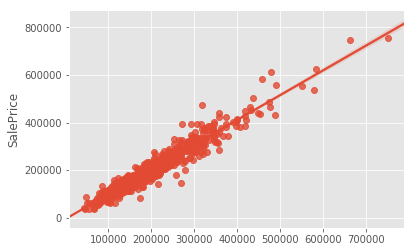

In [34]:
net.fit(X,yt)
net_pred=net.predict(X)
net_pred=((net_pred*lmda)+1)**(1/lmda)
sns.regplot(net_pred,act_pred)

## CatBoost

In [37]:
from catboost import CatBoostRegressor
catB = CatBoostRegressor(iterations=3000, random_seed=1, depth=5,
                        loss_function='RMSE')
catB.fit(X, yt)

Learning rate set to 0.018102
0:	learn: 0.1518620	total: 3.25ms	remaining: 9.74s
1:	learn: 0.1500538	total: 5.78ms	remaining: 8.67s
2:	learn: 0.1482669	total: 8.24ms	remaining: 8.23s
3:	learn: 0.1465452	total: 11.3ms	remaining: 8.46s
4:	learn: 0.1449003	total: 13.7ms	remaining: 8.21s
5:	learn: 0.1431763	total: 16ms	remaining: 8s
6:	learn: 0.1416235	total: 18.7ms	remaining: 7.99s
7:	learn: 0.1398936	total: 21.2ms	remaining: 7.92s
8:	learn: 0.1383474	total: 23.7ms	remaining: 7.89s
9:	learn: 0.1367867	total: 26.4ms	remaining: 7.9s
10:	learn: 0.1352560	total: 29ms	remaining: 7.88s
11:	learn: 0.1338080	total: 31.7ms	remaining: 7.88s
12:	learn: 0.1324559	total: 34ms	remaining: 7.8s
13:	learn: 0.1309299	total: 36.9ms	remaining: 7.87s
14:	learn: 0.1295830	total: 40.1ms	remaining: 7.98s
15:	learn: 0.1281371	total: 43ms	remaining: 8.01s
16:	learn: 0.1267530	total: 45.7ms	remaining: 8.02s
17:	learn: 0.1253540	total: 48.4ms	remaining: 8.03s
18:	learn: 0.1240230	total: 50.7ms	remaining: 7.95s
19:	l

200:	learn: 0.0489730	total: 366ms	remaining: 5.1s
201:	learn: 0.0488716	total: 369ms	remaining: 5.1s
202:	learn: 0.0487788	total: 371ms	remaining: 5.11s
203:	learn: 0.0487072	total: 374ms	remaining: 5.12s
204:	learn: 0.0486162	total: 376ms	remaining: 5.13s
205:	learn: 0.0485295	total: 379ms	remaining: 5.14s
206:	learn: 0.0484182	total: 381ms	remaining: 5.14s
207:	learn: 0.0483154	total: 384ms	remaining: 5.15s
208:	learn: 0.0482339	total: 386ms	remaining: 5.15s
209:	learn: 0.0481381	total: 388ms	remaining: 5.16s
210:	learn: 0.0480668	total: 391ms	remaining: 5.16s
211:	learn: 0.0479716	total: 393ms	remaining: 5.17s
212:	learn: 0.0478924	total: 397ms	remaining: 5.2s
213:	learn: 0.0478099	total: 401ms	remaining: 5.21s
214:	learn: 0.0477585	total: 403ms	remaining: 5.22s
215:	learn: 0.0476988	total: 407ms	remaining: 5.24s
216:	learn: 0.0476286	total: 410ms	remaining: 5.25s
217:	learn: 0.0475610	total: 412ms	remaining: 5.26s
218:	learn: 0.0474730	total: 415ms	remaining: 5.27s
219:	learn: 0.0

414:	learn: 0.0394667	total: 739ms	remaining: 4.6s
415:	learn: 0.0394425	total: 741ms	remaining: 4.6s
416:	learn: 0.0394198	total: 743ms	remaining: 4.6s
417:	learn: 0.0393956	total: 746ms	remaining: 4.61s
418:	learn: 0.0393591	total: 748ms	remaining: 4.61s
419:	learn: 0.0393394	total: 751ms	remaining: 4.61s
420:	learn: 0.0393060	total: 753ms	remaining: 4.61s
421:	learn: 0.0392825	total: 756ms	remaining: 4.62s
422:	learn: 0.0392530	total: 758ms	remaining: 4.62s
423:	learn: 0.0392289	total: 761ms	remaining: 4.62s
424:	learn: 0.0391976	total: 763ms	remaining: 4.62s
425:	learn: 0.0391793	total: 765ms	remaining: 4.62s
426:	learn: 0.0391560	total: 766ms	remaining: 4.62s
427:	learn: 0.0391237	total: 768ms	remaining: 4.61s
428:	learn: 0.0390890	total: 770ms	remaining: 4.61s
429:	learn: 0.0390486	total: 771ms	remaining: 4.61s
430:	learn: 0.0390290	total: 773ms	remaining: 4.6s
431:	learn: 0.0390057	total: 774ms	remaining: 4.6s
432:	learn: 0.0389897	total: 776ms	remaining: 4.6s
433:	learn: 0.0389

617:	learn: 0.0352415	total: 1.11s	remaining: 4.28s
618:	learn: 0.0352265	total: 1.11s	remaining: 4.28s
619:	learn: 0.0352188	total: 1.11s	remaining: 4.28s
620:	learn: 0.0352013	total: 1.12s	remaining: 4.28s
621:	learn: 0.0351816	total: 1.12s	remaining: 4.28s
622:	learn: 0.0351606	total: 1.12s	remaining: 4.29s
623:	learn: 0.0351542	total: 1.13s	remaining: 4.29s
624:	learn: 0.0351356	total: 1.13s	remaining: 4.29s
625:	learn: 0.0351218	total: 1.13s	remaining: 4.29s
626:	learn: 0.0351105	total: 1.13s	remaining: 4.29s
627:	learn: 0.0350947	total: 1.14s	remaining: 4.29s
628:	learn: 0.0350887	total: 1.14s	remaining: 4.29s
629:	learn: 0.0350751	total: 1.14s	remaining: 4.29s
630:	learn: 0.0350624	total: 1.14s	remaining: 4.29s
631:	learn: 0.0350430	total: 1.15s	remaining: 4.29s
632:	learn: 0.0350296	total: 1.15s	remaining: 4.29s
633:	learn: 0.0350180	total: 1.15s	remaining: 4.29s
634:	learn: 0.0349934	total: 1.15s	remaining: 4.29s
635:	learn: 0.0349831	total: 1.15s	remaining: 4.29s
636:	learn: 

831:	learn: 0.0322376	total: 1.48s	remaining: 3.87s
832:	learn: 0.0322239	total: 1.49s	remaining: 3.87s
833:	learn: 0.0322195	total: 1.49s	remaining: 3.87s
834:	learn: 0.0322107	total: 1.49s	remaining: 3.87s
835:	learn: 0.0321942	total: 1.49s	remaining: 3.87s
836:	learn: 0.0321833	total: 1.5s	remaining: 3.87s
837:	learn: 0.0321643	total: 1.5s	remaining: 3.87s
838:	learn: 0.0321458	total: 1.5s	remaining: 3.87s
839:	learn: 0.0321344	total: 1.51s	remaining: 3.88s
840:	learn: 0.0321232	total: 1.51s	remaining: 3.88s
841:	learn: 0.0321138	total: 1.52s	remaining: 3.88s
842:	learn: 0.0321020	total: 1.52s	remaining: 3.89s
843:	learn: 0.0320795	total: 1.52s	remaining: 3.89s
844:	learn: 0.0320684	total: 1.52s	remaining: 3.89s
845:	learn: 0.0320528	total: 1.53s	remaining: 3.89s
846:	learn: 0.0320399	total: 1.53s	remaining: 3.89s
847:	learn: 0.0320284	total: 1.53s	remaining: 3.89s
848:	learn: 0.0320172	total: 1.54s	remaining: 3.89s
849:	learn: 0.0320021	total: 1.54s	remaining: 3.89s
850:	learn: 0.0

1045:	learn: 0.0296232	total: 1.85s	remaining: 3.46s
1046:	learn: 0.0296077	total: 1.86s	remaining: 3.46s
1047:	learn: 0.0295975	total: 1.86s	remaining: 3.46s
1048:	learn: 0.0295853	total: 1.86s	remaining: 3.46s
1049:	learn: 0.0295806	total: 1.86s	remaining: 3.46s
1050:	learn: 0.0295641	total: 1.87s	remaining: 3.46s
1051:	learn: 0.0295539	total: 1.87s	remaining: 3.46s
1052:	learn: 0.0295418	total: 1.87s	remaining: 3.46s
1053:	learn: 0.0295312	total: 1.87s	remaining: 3.46s
1054:	learn: 0.0295190	total: 1.88s	remaining: 3.46s
1055:	learn: 0.0295023	total: 1.88s	remaining: 3.45s
1056:	learn: 0.0294944	total: 1.88s	remaining: 3.45s
1057:	learn: 0.0294755	total: 1.88s	remaining: 3.45s
1058:	learn: 0.0294613	total: 1.88s	remaining: 3.45s
1059:	learn: 0.0294516	total: 1.88s	remaining: 3.45s
1060:	learn: 0.0294426	total: 1.89s	remaining: 3.44s
1061:	learn: 0.0294317	total: 1.89s	remaining: 3.44s
1062:	learn: 0.0294152	total: 1.89s	remaining: 3.44s
1063:	learn: 0.0294059	total: 1.89s	remaining:

1261:	learn: 0.0271202	total: 2.23s	remaining: 3.07s
1262:	learn: 0.0271082	total: 2.23s	remaining: 3.07s
1263:	learn: 0.0270973	total: 2.23s	remaining: 3.06s
1264:	learn: 0.0270810	total: 2.23s	remaining: 3.06s
1265:	learn: 0.0270629	total: 2.24s	remaining: 3.06s
1266:	learn: 0.0270511	total: 2.24s	remaining: 3.06s
1267:	learn: 0.0270432	total: 2.24s	remaining: 3.06s
1268:	learn: 0.0270321	total: 2.24s	remaining: 3.06s
1269:	learn: 0.0270242	total: 2.25s	remaining: 3.06s
1270:	learn: 0.0270230	total: 2.25s	remaining: 3.06s
1271:	learn: 0.0270089	total: 2.25s	remaining: 3.06s
1272:	learn: 0.0269995	total: 2.25s	remaining: 3.06s
1273:	learn: 0.0269865	total: 2.25s	remaining: 3.06s
1274:	learn: 0.0269711	total: 2.26s	remaining: 3.05s
1275:	learn: 0.0269553	total: 2.26s	remaining: 3.05s
1276:	learn: 0.0269478	total: 2.26s	remaining: 3.05s
1277:	learn: 0.0269352	total: 2.26s	remaining: 3.05s
1278:	learn: 0.0269240	total: 2.26s	remaining: 3.04s
1279:	learn: 0.0269152	total: 2.26s	remaining:

1488:	learn: 0.0249933	total: 2.6s	remaining: 2.64s
1489:	learn: 0.0249814	total: 2.6s	remaining: 2.64s
1490:	learn: 0.0249685	total: 2.6s	remaining: 2.63s
1491:	learn: 0.0249599	total: 2.6s	remaining: 2.63s
1492:	learn: 0.0249507	total: 2.61s	remaining: 2.63s
1493:	learn: 0.0249388	total: 2.61s	remaining: 2.63s
1494:	learn: 0.0249303	total: 2.61s	remaining: 2.63s
1495:	learn: 0.0249244	total: 2.61s	remaining: 2.63s
1496:	learn: 0.0249145	total: 2.62s	remaining: 2.63s
1497:	learn: 0.0249104	total: 2.62s	remaining: 2.63s
1498:	learn: 0.0249020	total: 2.62s	remaining: 2.62s
1499:	learn: 0.0248956	total: 2.62s	remaining: 2.62s
1500:	learn: 0.0248855	total: 2.63s	remaining: 2.62s
1501:	learn: 0.0248676	total: 2.63s	remaining: 2.62s
1502:	learn: 0.0248670	total: 2.63s	remaining: 2.62s
1503:	learn: 0.0248521	total: 2.63s	remaining: 2.62s
1504:	learn: 0.0248376	total: 2.63s	remaining: 2.62s
1505:	learn: 0.0248368	total: 2.63s	remaining: 2.61s
1506:	learn: 0.0248215	total: 2.64s	remaining: 2.6

1719:	learn: 0.0230285	total: 2.97s	remaining: 2.21s
1720:	learn: 0.0230170	total: 2.97s	remaining: 2.21s
1721:	learn: 0.0229996	total: 2.98s	remaining: 2.21s
1722:	learn: 0.0229952	total: 2.98s	remaining: 2.21s
1723:	learn: 0.0229842	total: 2.98s	remaining: 2.21s
1724:	learn: 0.0229836	total: 2.98s	remaining: 2.21s
1725:	learn: 0.0229741	total: 2.99s	remaining: 2.21s
1726:	learn: 0.0229698	total: 2.99s	remaining: 2.2s
1727:	learn: 0.0229639	total: 2.99s	remaining: 2.2s
1728:	learn: 0.0229543	total: 3s	remaining: 2.2s
1729:	learn: 0.0229501	total: 3s	remaining: 2.2s
1730:	learn: 0.0229443	total: 3s	remaining: 2.2s
1731:	learn: 0.0229400	total: 3s	remaining: 2.2s
1732:	learn: 0.0229326	total: 3s	remaining: 2.2s
1733:	learn: 0.0229240	total: 3s	remaining: 2.19s
1734:	learn: 0.0229170	total: 3.01s	remaining: 2.19s
1735:	learn: 0.0229072	total: 3.01s	remaining: 2.19s
1736:	learn: 0.0228952	total: 3.01s	remaining: 2.19s
1737:	learn: 0.0228895	total: 3.01s	remaining: 2.19s
1738:	learn: 0.022

1945:	learn: 0.0213360	total: 3.35s	remaining: 1.81s
1946:	learn: 0.0213274	total: 3.35s	remaining: 1.81s
1947:	learn: 0.0213189	total: 3.35s	remaining: 1.81s
1948:	learn: 0.0213162	total: 3.35s	remaining: 1.81s
1949:	learn: 0.0213092	total: 3.35s	remaining: 1.81s
1950:	learn: 0.0213035	total: 3.36s	remaining: 1.8s
1951:	learn: 0.0212983	total: 3.36s	remaining: 1.8s
1952:	learn: 0.0212921	total: 3.36s	remaining: 1.8s
1953:	learn: 0.0212850	total: 3.36s	remaining: 1.8s
1954:	learn: 0.0212802	total: 3.37s	remaining: 1.8s
1955:	learn: 0.0212733	total: 3.37s	remaining: 1.8s
1956:	learn: 0.0212680	total: 3.37s	remaining: 1.79s
1957:	learn: 0.0212577	total: 3.37s	remaining: 1.79s
1958:	learn: 0.0212471	total: 3.37s	remaining: 1.79s
1959:	learn: 0.0212390	total: 3.37s	remaining: 1.79s
1960:	learn: 0.0212318	total: 3.38s	remaining: 1.79s
1961:	learn: 0.0212226	total: 3.38s	remaining: 1.79s
1962:	learn: 0.0212154	total: 3.38s	remaining: 1.78s
1963:	learn: 0.0212063	total: 3.38s	remaining: 1.78s

2175:	learn: 0.0198044	total: 3.72s	remaining: 1.41s
2176:	learn: 0.0197972	total: 3.72s	remaining: 1.41s
2177:	learn: 0.0197876	total: 3.72s	remaining: 1.41s
2178:	learn: 0.0197797	total: 3.73s	remaining: 1.4s
2179:	learn: 0.0197728	total: 3.73s	remaining: 1.4s
2180:	learn: 0.0197659	total: 3.73s	remaining: 1.4s
2181:	learn: 0.0197567	total: 3.73s	remaining: 1.4s
2182:	learn: 0.0197485	total: 3.74s	remaining: 1.4s
2183:	learn: 0.0197481	total: 3.74s	remaining: 1.4s
2184:	learn: 0.0197478	total: 3.74s	remaining: 1.4s
2185:	learn: 0.0197439	total: 3.74s	remaining: 1.39s
2186:	learn: 0.0197355	total: 3.74s	remaining: 1.39s
2187:	learn: 0.0197352	total: 3.74s	remaining: 1.39s
2188:	learn: 0.0197289	total: 3.75s	remaining: 1.39s
2189:	learn: 0.0197212	total: 3.75s	remaining: 1.39s
2190:	learn: 0.0197171	total: 3.75s	remaining: 1.38s
2191:	learn: 0.0197108	total: 3.75s	remaining: 1.38s
2192:	learn: 0.0196998	total: 3.75s	remaining: 1.38s
2193:	learn: 0.0196946	total: 3.75s	remaining: 1.38s


2404:	learn: 0.0184880	total: 4.09s	remaining: 1.01s
2405:	learn: 0.0184821	total: 4.09s	remaining: 1.01s
2406:	learn: 0.0184758	total: 4.1s	remaining: 1.01s
2407:	learn: 0.0184702	total: 4.1s	remaining: 1.01s
2408:	learn: 0.0184665	total: 4.1s	remaining: 1.01s
2409:	learn: 0.0184641	total: 4.1s	remaining: 1s
2410:	learn: 0.0184572	total: 4.11s	remaining: 1s
2411:	learn: 0.0184467	total: 4.11s	remaining: 1s
2412:	learn: 0.0184384	total: 4.11s	remaining: 1s
2413:	learn: 0.0184344	total: 4.11s	remaining: 999ms
2414:	learn: 0.0184316	total: 4.11s	remaining: 997ms
2415:	learn: 0.0184225	total: 4.12s	remaining: 995ms
2416:	learn: 0.0184179	total: 4.12s	remaining: 993ms
2417:	learn: 0.0184113	total: 4.12s	remaining: 992ms
2418:	learn: 0.0184060	total: 4.12s	remaining: 990ms
2419:	learn: 0.0184028	total: 4.12s	remaining: 988ms
2420:	learn: 0.0183977	total: 4.13s	remaining: 987ms
2421:	learn: 0.0183894	total: 4.13s	remaining: 985ms
2422:	learn: 0.0183837	total: 4.13s	remaining: 983ms
2423:	lea

2635:	learn: 0.0173359	total: 4.46s	remaining: 616ms
2636:	learn: 0.0173316	total: 4.46s	remaining: 615ms
2637:	learn: 0.0173313	total: 4.47s	remaining: 613ms
2638:	learn: 0.0173223	total: 4.47s	remaining: 612ms
2639:	learn: 0.0173153	total: 4.47s	remaining: 610ms
2640:	learn: 0.0173097	total: 4.48s	remaining: 609ms
2641:	learn: 0.0173047	total: 4.48s	remaining: 607ms
2642:	learn: 0.0172964	total: 4.48s	remaining: 605ms
2643:	learn: 0.0172920	total: 4.48s	remaining: 604ms
2644:	learn: 0.0172896	total: 4.49s	remaining: 602ms
2645:	learn: 0.0172844	total: 4.49s	remaining: 600ms
2646:	learn: 0.0172755	total: 4.49s	remaining: 599ms
2647:	learn: 0.0172696	total: 4.49s	remaining: 597ms
2648:	learn: 0.0172637	total: 4.49s	remaining: 595ms
2649:	learn: 0.0172567	total: 4.5s	remaining: 594ms
2650:	learn: 0.0172508	total: 4.5s	remaining: 592ms
2651:	learn: 0.0172465	total: 4.5s	remaining: 590ms
2652:	learn: 0.0172433	total: 4.5s	remaining: 589ms
2653:	learn: 0.0172359	total: 4.5s	remaining: 587m

2858:	learn: 0.0162935	total: 4.84s	remaining: 239ms
2859:	learn: 0.0162886	total: 4.84s	remaining: 237ms
2860:	learn: 0.0162824	total: 4.84s	remaining: 235ms
2861:	learn: 0.0162785	total: 4.85s	remaining: 234ms
2862:	learn: 0.0162713	total: 4.85s	remaining: 232ms
2863:	learn: 0.0162650	total: 4.85s	remaining: 230ms
2864:	learn: 0.0162600	total: 4.86s	remaining: 229ms
2865:	learn: 0.0162556	total: 4.86s	remaining: 227ms
2866:	learn: 0.0162529	total: 4.86s	remaining: 226ms
2867:	learn: 0.0162465	total: 4.86s	remaining: 224ms
2868:	learn: 0.0162408	total: 4.87s	remaining: 222ms
2869:	learn: 0.0162382	total: 4.87s	remaining: 220ms
2870:	learn: 0.0162307	total: 4.87s	remaining: 219ms
2871:	learn: 0.0162245	total: 4.87s	remaining: 217ms
2872:	learn: 0.0162190	total: 4.87s	remaining: 215ms
2873:	learn: 0.0162144	total: 4.87s	remaining: 214ms
2874:	learn: 0.0162141	total: 4.87s	remaining: 212ms
2875:	learn: 0.0162075	total: 4.88s	remaining: 210ms
2876:	learn: 0.0162007	total: 4.88s	remaining:

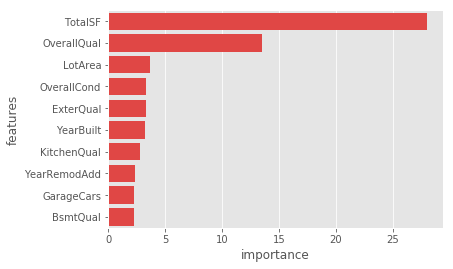

In [38]:
col = np.array(X.columns)
feat = catB.feature_importances_
df = pd.DataFrame(feat, col).reset_index().rename({'index': 'features', 0: 'importance'}, axis = 1).sort_values('importance', ascending=False).head(10)
sns.barplot(x="importance", y="features", data=df, color='#FA2E2B')

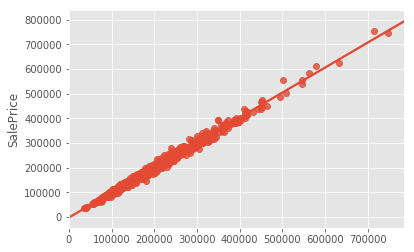

In [39]:
cat_pred=catB.predict(X)
cat_pred=((cat_pred*lmda)+1)**(1/lmda)
sns.regplot(cat_pred,act_pred)

## LightGBM

In [40]:
lgb_= lgb.LGBMRegressor(objective='regression',num_leaves=8,
                              learning_rate=0.05, n_estimators=760,
                              max_bin = 55, bagging_fraction = 0.667,
                              bagging_freq = 5, feature_fraction = 0.4181818181818182,
                              feature_fraction_seed=1, bagging_seed=1,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 5)
lgb_.fit(X,yt)

LGBMRegressor(bagging_fraction=0.667, bagging_freq=5, bagging_seed=1,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.4181818181818182, feature_fraction_seed=1,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0, min_sum_hessian_in_leaf=5,
              n_estimators=760, n_jobs=-1, num_leaves=8, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

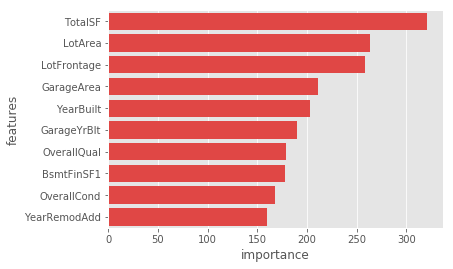

In [41]:
col = np.array(X.columns)
feat = lgb_.feature_importances_
df = pd.DataFrame(feat, col).reset_index().rename({'index': 'features', 0: 'importance'}, axis = 1).sort_values('importance', ascending=False).head(10)
sns.barplot(x="importance", y="features", data=df, color='#FA2E2B')

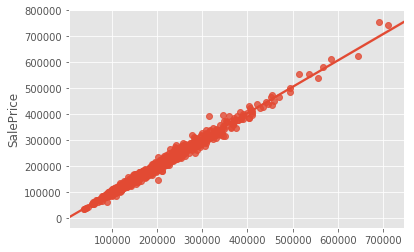

In [42]:
lgb_pred=lgb_.predict(X)
lgb_pred=((lgb_pred*lmda)+1)**(1/lmda)
sns.regplot(lgb_pred,act_pred)

## Gradient Boost

In [43]:
gb = GradientBoostingRegressor(n_estimators=3000,
                               learning_rate=0.05,
                               max_depth=2,
                               max_features='sqrt',
                               min_samples_leaf=3,
                               min_samples_split=14, 
                               loss='huber', 
                               random_state =5)
gb.fit(X,yt)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='huber',
                          max_depth=2, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=14,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=5, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

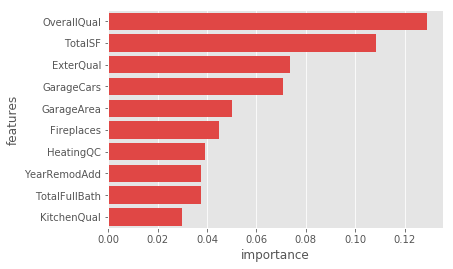

In [44]:
col = np.array(X.columns)
feat = gb.feature_importances_
df = pd.DataFrame(feat, col).reset_index().rename({'index': 'features', 0: 'importance'}, axis = 1).sort_values('importance', ascending=False).head(10)
sns.barplot(x="importance", y="features", data=df, color='#FA2E2B')

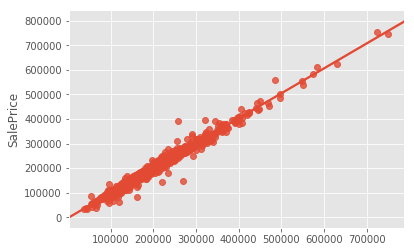

In [45]:
gb_pred=gb.predict(X)
gb_pred=((gb_pred*lmda)+1)**(1/lmda)
sns.regplot(gb_pred,act_pred)